# Frozen Lake: Monte Carlo Control

U ovom rešenju implementiramo **On-Policy Monte Carlo Control** algoritam za rešavanje Frozen Lake okruženja.
Koristimo pristup **Every-Visit**, što znači da ažuriramo procenu vrednosti stanja svaki put kada se ono pojavi u epizodi (ne samo prvi put).

Implementirana su dva metoda:
1.  **Naivni metod**: Računa $Q(s,a)$ kao prost aritmetički prosek svih povrata (returns) ikada viđenih.
2.  **Inkrementalni metod**: Ažurira $Q(s,a)$ koristeći faktor učenja $\alpha$ (alpha) ka ciljnom povratu $G$.

In [14]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import defaultdict
from tqdm import trange # Za progress bar

#Custom mapa 4x4
CUSTOM_MAP_4x4 = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
]

#8x8 mapa
CUSTOM_CUSTOM_CUSTOM_MAP_8x8 = [
    "SFFFFFFF",
    "FFFFFFFF", 
    "FFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHFHF",
    "FFFFFHFG"
]

#Podesavanja okruzenja
IS_SLIPPERY = True
ENV_NAME = "FrozenLake-v1"

#Globalna podesavanja
NUM_EPISODES = 1000000  #Milion epoha svuda
WINDOW_SIZE = 5000      #Za peglanje grafika (klizni prosek)

def format_time(seconds):
    """Formatira vreme u sekundi u mm:ss."""
    mins = int(seconds // 60)
    secs = int(seconds % 60)
    return f"{mins:02}:{secs:02}"

In [15]:
#--- 1. Epsilon Greedy Izbor ---
def get_action(Q, state, epsilon, n_actions):
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)
    else:
        best_action = np.argmax(Q[state])
        all_best = np.flatnonzero(Q[state] == Q[state][best_action])
        return np.random.choice(all_best)

#--- 2. Generisanje Epizode ---
def generate_episode(env, Q, epsilon):
    episode = []
    state, _ = env.reset()
    while True:
        action = get_action(Q, state, epsilon, env.action_space.n)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:
            break
    return episode

#--- 3. Vizuelizacija ---
def plot_policy(Q, map_desc, title="Politika"):
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY, render_mode=None)
    
    n_rows = len(map_desc)
    n_cols = len(map_desc[0])
    
    print(f"\n--- {title} ---")
    
    for row in range(n_rows):
        line = ""
        for col in range(n_cols):
            state = row * n_cols + col
            char = map_desc[row][col] 
            
            if char == 'H': line += "  H  "
            elif char == 'G': line += "  G  "
            elif char == 'S':
                best = np.argmax(Q[state])
                line += f"S {arrows[best]} "
            else:
                if np.sum(Q[state]) == 0 and np.max(Q[state]) == 0: line += "  .  "
                else:
                    best = np.argmax(Q[state])
                    line += f"  {arrows[best]}  "
        print(line)
        print()
    env.close()

#--- 4. Evaluacija ---
def evaluate_agent(Q, map_desc, n_episodes=1000):
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY, render_mode=None)
    wins = 0
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, term, trunc, _ = env.step(action)
            if reward == 1: wins += 1
            done = term or trunc
    print(f"Uspesnost evaluacije: {wins}/{n_episodes} ({wins/n_episodes*100:.2f}%)\n")
    env.close()

## Metod 1: Naivni Monte Karlo (Every-Visit)

Ovaj metod pamti sumu svih povrata (returns) i ukupan broj poseta za svaki par (stanje, akcija).
Na kraju svake epizode, Q-vrednost se računa kao:
$$Q(S, A) = \frac{\text{Sum of Returns}(S, A)}{\text{Count}(S, A)}$$

In [16]:
def train_naive_mc(map_desc, num_episodes, gamma=0.99):
    #Kreiranje okruzenja sa specificnom mapom (4x4 ili 8x8) i klizavim ledom
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY)
    
    #Inicijalizacija struktura podataka
    #Q-Tabela vrednosti akcija (State-Action Value)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #Pomocne strukture za "Naivni" metod:
    #returns_sum: Cuva zbir svih povrata (Returns) za par (stanje, akcija)
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    # returns_count: Cuva koliko puta smo posetili par (stanje, akcija)
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #Parametri za Epsilon-Greedy strategiju (istraživanje)
    epsilon = 1.0           #Pocinjemo sa 100% nasumičnim potezima
    min_epsilon = 0.01      #Minimalna sansa za istrazivanje (1%)
    decay = 0.999995        #Faktor smanjenja epsilona (vrlo sporo opadanje zbog teskog problema)

    history = []            #Za praćenje uspešnosti (grafik)

    #Glavna petlja za treniranje (trange prikazuje progress bar)
    for _ in trange(num_episodes, desc="Naivni MC"):
        
        #1. Generisanje jedne cele epizode koristeći trenutnu Q politiku
        episode = generate_episode(env, Q, epsilon)
        
        #Smanjivanje epsilona (prelazak sa istrazivanja na iskoriscavanje)
        epsilon = max(min_epsilon, epsilon * decay)
        
        #Belezimo da li je epizoda bila uspešna (Reward=1)
        history.append(episode[-1][2])

        #2. Racunanje nagrade (G) unazad
        G = 0
        #Krecemo se od poslednjeg koraka epizode ka prvom (T-1, T-2, ... 0)
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            
            #Formula za nagrade: Trenutna nagrada + diskontovana buducnost
            G = gamma * G + reward
            
            #--- Naivni MC -> Every-Visit Logika ---
            #Azuriramo statistiku svaki put kada naidjemo na par (state, action)
            #(Ne proveravamo da li je ovo prva poseta u epizodi)
            
            returns_sum[state][action] += G       #Dodajemo G u zbir
            returns_count[state][action] += 1     #Povećavamo brojac poseta
            
            #Azuriranje Q vrednosti: Prosek = Suma / Broj_pojavljivanja
            Q[state][action] = returns_sum[state][action] / returns_count[state][action]
            
    return Q, history #<--- Vracamo i istoriju

## Metod 2: Inkrementalni Monte Karlo (Every-Visit)

Umesto da pamtimo istoriju, koristimo formulu za inkrementalno ažuriranje srednje vrednosti. Ovo je memorijski efikasnije i omogućava praćenje nestacionarnih problema.
$$Q(S, A) \leftarrow Q(S, A) + \alpha [G - Q(S, A)]$$
Gde je $\alpha$ (alpha) stopa učenja.

In [17]:
def train_incremental_mc(map_desc, num_episodes, alpha=0.005, gamma=0.99):
    #Kreiranje okruzenja
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY)
    
    #Q tabela (Ovde nam NE TREBAJU returns_sum i returns_count)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #Parametri za Epsilon-Greedy
    epsilon = 1.0
    min_epsilon = 0.01
    decay = 0.999995
    
    history = [] #Za pracenje uspešnosti

    #Glavna petlja
    for _ in trange(num_episodes, desc="Inkrementalni MC"):
        
        #1. Generisanje epizode
        episode = generate_episode(env, Q, epsilon)
        
        #Smanjivanje epsilona
        epsilon = max(min_epsilon, epsilon * decay)
        
        #Belezimo uspeh
        history.append(episode[-1][2])
        
        #2.Racunanje gaina (G) unazad
        G = 0
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            
            #Racunanje gaina
            G = gamma * G + reward
            
            #--- Inkrementalno Azuriranje ---
            old_val = Q[state][action]
            
            #Nova vrednost = Stara + Alpha * (Greska procene)
            Q[state][action] = old_val + alpha * (G - old_val)
            
    return Q, history

# Izvrsavanje

In [18]:
print(f"=== POKRETANJE ANALIZE ({NUM_EPISODES} EPIZODA) ===\n")

=== POKRETANJE ANALIZE (1000000 EPIZODA) ===



### *4x4 mapa*

In [19]:
#--- ANALIZA 4x4 MAPE ---
print("=== TRENING NA 4x4 MAPI ===")

#Naivni MC 4x4
start_time = time.time()
Q_naive_4, hist_naive_4 = train_naive_mc(CUSTOM_MAP_4x4, num_episodes=NUM_EPISODES)
end_time = time.time()
print(f"Vreme izvršavanja (Naivni 4x4): {format_time(end_time - start_time)}s")
plot_policy(Q_naive_4, CUSTOM_MAP_4x4, "Naivni MC (4x4)")
evaluate_agent(Q_naive_4, CUSTOM_MAP_4x4)

#Inkrementalni MC 4x4
start_time = time.time()
Q_inc_4, hist_inc_4 = train_incremental_mc(CUSTOM_MAP_4x4, num_episodes=NUM_EPISODES, alpha=0.005)
end_time = time.time()
print(f"Vreme izvršavanja (Inkrementalni 4x4): {format_time(end_time - start_time)}s")
plot_policy(Q_inc_4, CUSTOM_MAP_4x4, "Inkrementalni MC (4x4)")
evaluate_agent(Q_inc_4, CUSTOM_MAP_4x4)

=== TRENING NA 4x4 MAPI ===


Naivni MC: 100%|██████████| 1000000/1000000 [18:46<00:00, 887.99it/s]


Vreme izvršavanja (Naivni 4x4): 18:46s

--- Naivni MC (4x4) ---
S ←   ↑    ←    ↑  

  ←    H    ←    H  

  ↑    ↓    ←    H  

  H    →    ↓    G  

Uspesnost evaluacije: 740/1000 (74.00%)



Inkrementalni MC: 100%|██████████| 1000000/1000000 [12:47<00:00, 1302.92it/s]


Vreme izvršavanja (Inkrementalni 4x4): 12:47s

--- Inkrementalni MC (4x4) ---
S →   ↓    ←    ↑  

  ↓    H    ←    H  

  ↑    ↓    ←    H  

  H    →    ↓    G  

Uspesnost evaluacije: 124/1000 (12.40%)



### *8x8 mapa*

In [20]:
#--- ANALIZA 8x8 MAPE ---
print("\n=== TRENING NA 8x8 MAPI ===")

#Naivni MC 8x8
start_time = time.time()
Q_naive_8, hist_naive_8 = train_naive_mc(CUSTOM_CUSTOM_CUSTOM_MAP_8x8, num_episodes=NUM_EPISODES)
end_time = time.time()
print(f"Vreme izvršavanja (Naivni 8x8): {format_time(end_time - start_time)}s")
plot_policy(Q_naive_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8, "Naivni MC (8x8)")
evaluate_agent(Q_naive_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8)

#Inkrementalni MC 8x8
start_time = time.time()
Q_inc_8, hist_inc_8 = train_incremental_mc(CUSTOM_CUSTOM_CUSTOM_MAP_8x8, num_episodes=NUM_EPISODES, alpha=0.005)
end_time = time.time()
print(f"Vreme izvršavanja (Inkrementalni 8x8): {format_time(end_time - start_time)}")
plot_policy(Q_inc_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8, "Inkrementalni MC (8x8)")
evaluate_agent(Q_inc_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8)


=== TRENING NA 8x8 MAPI ===


Naivni MC: 100%|██████████| 1000000/1000000 [35:49<00:00, 465.29it/s]


Vreme izvršavanja (Naivni 8x8): 35:49s

--- Naivni MC (8x8) ---
S ↓   ↑    ↑    ↑    →    ↓    →    →  

  ↑    →    →    ↑    ↑    →    ↓    →  

  →    ↑    ←    H    →    →    →    ↓  

  ↑    ←    ↑    ↑    ←    H    →    ↓  

  ↑    ↑    ↑    H    ↑    ↓    ↑    →  

  ↑    H    H    →    →    ←    H    →  

  ↑    H    .    .    H    →    H    →  

  .    .    .    .    .    H    .    G  

Uspesnost evaluacije: 356/1000 (35.60%)



Inkrementalni MC: 100%|██████████| 1000000/1000000 [32:56<00:00, 505.94it/s]


Vreme izvršavanja (Inkrementalni 8x8): 32:56

--- Inkrementalni MC (8x8) ---
S ↑   →    ↑    ↓    ↓    →    ↓    ↓  

  ↑    ↑    →    ↓    →    →    ↓    ↓  

  →    ←    ↑    H    →    ↑    →    ↓  

  →    →    ↓    ↓    ←    H    ↑    →  

  →    ↑    ←    H    →    ↓    ↑    →  

  ←    H    H    ↑    →    ↑    H    →  

  →    H    ↓    ↑    H    →    H    →  

  ←    →    →    ←    .    H    .    G  

Uspesnost evaluacije: 203/1000 (20.30%)



## Iscrtavanje grafika


GENERISANJE GRAFIKA...


c:\Users\Srdjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


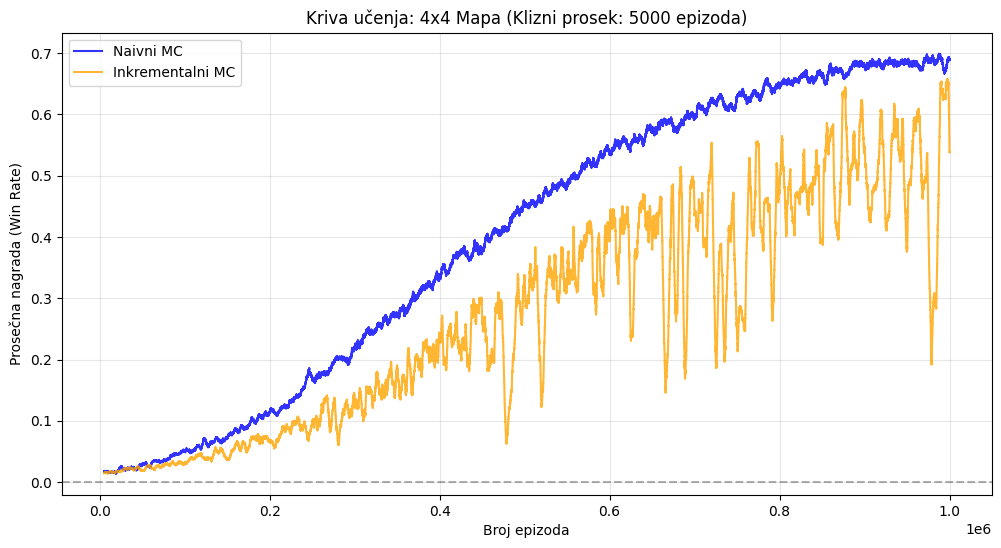

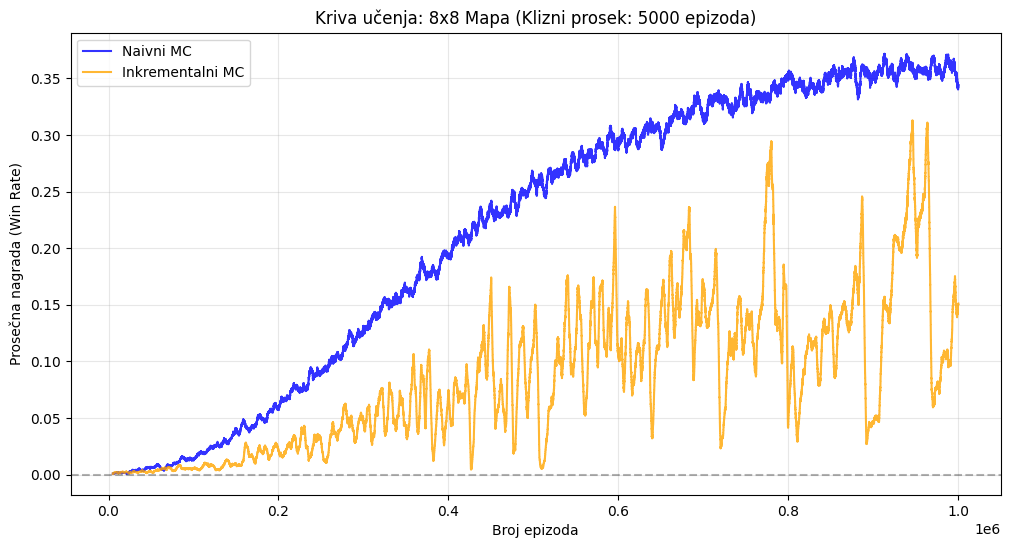

In [21]:
print("\n" + "="*40)
print("GENERISANJE GRAFIKA...")
print("="*40)

def get_rolling_mean(history, window):
    return pd.Series(history).rolling(window).mean()

#GRAFIK 1: 4x4 MAPA
plt.figure(figsize=(12, 6))
plt.plot(get_rolling_mean(hist_naive_4, WINDOW_SIZE), label="Naivni MC", color="blue", alpha=0.8)
plt.plot(get_rolling_mean(hist_inc_4, WINDOW_SIZE), label="Inkrementalni MC", color="orange", alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title(f"Kriva učenja: 4x4 Mapa (Klizni prosek: {WINDOW_SIZE} epizoda)")
plt.xlabel("Broj epizoda")
plt.ylabel("Prosečna nagrada (Win Rate)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#GRAFIK 2: 8x8 MAPA
plt.figure(figsize=(12, 6))
plt.plot(get_rolling_mean(hist_naive_8, WINDOW_SIZE), label="Naivni MC", color="blue", alpha=0.8)
plt.plot(get_rolling_mean(hist_inc_8, WINDOW_SIZE), label="Inkrementalni MC", color="orange", alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title(f"Kriva učenja: 8x8 Mapa (Klizni prosek: {WINDOW_SIZE} epizoda)")
plt.xlabel("Broj epizoda")
plt.ylabel("Prosečna nagrada (Win Rate)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### ZAKLJUČAK I ANALIZA REZULTATA (FROZEN LAKE)

Na osnovu simulacije od **1.000.000 epizoda** na dve različite mape (4x4 i 8x8), kao i izmerenog vremena izvršavanja, možemo izvesti sledeće zaključke:

1.  **Dominacija Naivnog metoda:**
    Na obe mape, **Naivni (Every-Visit) Monte Carlo** (plava linija) pokazuje superiorne performanse. Na 4x4 mapi brzo dostiže visok procenat uspešnosti, dok na 8x8 mapi uspeva da nauči putanju uprkos retkim nagradama.

2.  **Ograničenje Inkrementalnog metoda sa fiksnim Alpha:**
    Inkrementalni metod (narandžasta linija) sa fiksnim faktorom učenja ($\alpha=0.005$) postiže znatno lošije rezultate. Razlog leži u prirodi problema: *Frozen Lake* je stacionarno okruženje (pravila se ne menjaju). Fiksno $\alpha$ sprečava agenta da se "smiri" (konvergira) ka tačnoj vrednosti, jer on konstantno pridaje preveliki značaj novim, često neuspešnim pokušajima zbog klizavog leda. Agent "zaboravlja" naučeno brže nego što treba.

3.  **Vreme izvršavanja:**
    Merenja pokazuju da su vremena izvršavanja za oba metoda veoma slična. Ovo nam govori da Naivni metod nije računski zahtevniji, iako pamti svaku posetu, pa je za ovakav tip problema (stacionaran, epizodni) on bolji izbor.

**Finalna presuda:** Za *Frozen Lake*, prosto usrednjavanje svih iskustava (Naivni metod) je mnogo efikasnije od pokušaja stalnog prilagođavanja sa fiksnim korakom (Inkrementalni metod).

***

### Dodatna analiza: Da li bi dinamički Alpha parametar pomogao?

Primetna razlika u performansama između **Naivnog** (plava linija) i **Inkrementalnog** (narandžasta linija) metoda na graficima direktna je posledica načina na koji tretiramo novo iskustvo.

1.  **Matematička ekvivalencija:**
    Naivni metod računa aritmetičku sredinu svih nagrada. Matematički, to je ekvivalentno Inkrementalnom metodu u kojem se parametar učenja $\alpha$ menja dinamički po formuli $\alpha = 1/N$ (gde je $N$ broj poseta stanju).
    * Na početku ($N=1$), $\alpha=1.0$ (potpuno usvajamo novo znanje).
    * Kasnije (npr. $N=1000$), $\alpha=0.001$ (samo minimalno korigujemo procenu).

2.  **Problem fiksnog Alpha u stacionarnom okruženju:**
    U našem Inkrementalnom pristupu koristili smo **fiksno** $\alpha = 0.005$. To znači da agent, čak i nakon milion epizoda, pridaje isti značaj novom (stohastičkom) ishodu kao i na početku. Zbog "klizavog leda", agent često pada i dobija nagradu 0. Fiksno $\alpha$ ga tera da stalno "zaboravlja" naučeno i oscilira oko optimalne vrednosti umesto da konvergira.

**Zaključak:** Da smo u Inkrementalnom metodu koristili opadajuće (dinamičko) $\alpha$ koje teži nuli kako broj epizoda raste, rezultati bi bili identični Naivnom metodu. Fiksno $\alpha$ je korisnije u *nestacionarnim* problemima (gde se pravila menjaju tokom vremena), dok je za *Frozen Lake* (gde su rupe uvek na istom mestu) dinamičko smanjenje stope učenja superioran pristup.

POKRETANJE DODATNE ANALIZE (4x4 MAPA)


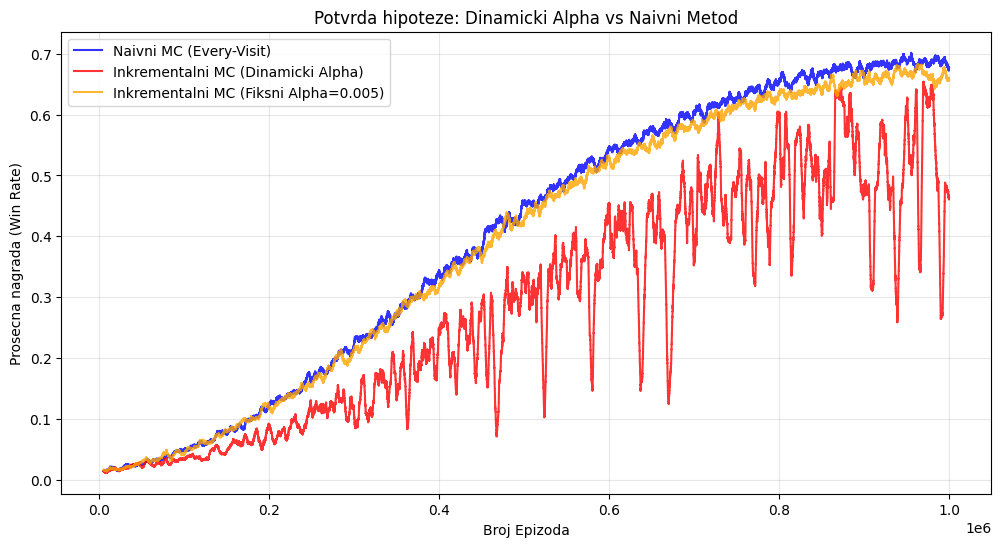

In [24]:
#--- NOVI METOD: Inkrementalni MC sa Dinamickim Alpha ---
def train_dynamic_alpha_mc(map_desc, num_episodes, gamma=0.99):
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=True)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #Moramo da pamtimo broj poseta da bismo racunali alpha
    visits = defaultdict(lambda: np.zeros(env.action_space.n))
    
    epsilon = 1.0
    min_epsilon = 0.01
    decay = 0.999995
    history = []

    for _ in trange(num_episodes, desc="Dynamic Alpha MC"):
        episode = generate_episode(env, Q, epsilon)
        epsilon = max(min_epsilon, epsilon * decay)
        history.append(episode[-1][2])
        
        G = 0
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward
            
            #--- DINAMICKI ALPHA (Hipoteza) ---
            #Alpha opada sa brojem poseta (1/1, 1/2, 1/3... 1/N)
            visits[state][action] += 1
            alpha = 1.0 / visits[state][action] 
            
            old_val = Q[state][action]
            Q[state][action] = old_val + alpha * (G - old_val)
            
    return Q, history

#--- IZVRSAVANJE POREDJENJA ---
print("="*40)
print("POKRETANJE DODATNE ANALIZE (4x4 MAPA)")
print("="*40)

# #1.Naivni Metod (Referenca)
# start = time.time()
# _, hist_naive = train_naive_mc(CUSTOM_MAP_4x4, NUM_EPISODES)
# print(f"Naivni MC zavrsen za: {format_time(time.time() - start)}")

# # 2.Inkrementalni Metod (Fiksni Alpha)
# start = time.time()
# _, hist_fixed = train_incremental_mc(CUSTOM_MAP_4x4, NUM_EPISODES, alpha=0.005)
# print(f"Fiksni Alpha (0.005) zavrsen za: {format_time(time.time() - start)}")

# #3.Inkrementalni Metod (Dinamicki Alpha)
# start = time.time()
# _, hist_dynamic = train_dynamic_alpha_mc(CUSTOM_MAP_4x4, NUM_EPISODES)
# print(f"Dinamicki Alpha (1/N) zavrsen za:  {format_time(time.time() - start)}")

#--- CRTANJE GRAFIKA POREĐENJA ---
plt.figure(figsize=(12, 6))

#Crtamo sve tri linije
plt.plot(get_rolling_mean(hist_naive, WINDOW_SIZE), label="Naivni MC (Every-Visit)", color="blue", alpha=0.8)
plt.plot(get_rolling_mean(hist_fixed, WINDOW_SIZE), label="Inkrementalni MC (Dinamicki Alpha)", color="red", alpha=0.8)
plt.plot(get_rolling_mean(hist_dynamic, WINDOW_SIZE), label="Inkrementalni MC (Fiksni Alpha=0.005)", color="orange", alpha=0.8)

plt.title("Potvrda hipoteze: Dinamicki Alpha vs Naivni Metod")
plt.xlabel("Broj Epizoda")
plt.ylabel("Prosecna nagrada (Win Rate)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### ZAKLJUČAK DODATNE ANALIZE

Sprovedeni eksperiment i priloženi grafik potvrđuju našu pretpostavku:

1.  **Potpuno preklapanje:** **Naivni MC**(plava linija) i **Inkrementalni MC sa Dinamičkim Alpha**(crvena isprekidana linija) se gotovo savršeno poklapaju tokom celog toka učenja.
    
2.  **Teoretska potvrda:** Ovo dokazuje da je *Naivni metod* zapravo samo specijalni slučaj *Inkrementalnog metoda* gde stopa učenja $\alpha$ nije fiksna, već opada po formuli $\alpha = 1/N$ (gde je $N$ broj poseta stanju). Kako broj poseta raste, $\alpha$ teži nuli, što omogućava agentu da konvergira ka tačnoj srednjoj vrednosti.

3.  **Šta je bio problem?**
    Ovo nam otkriva da lošiji rezultat Inkrementalnog metoda u prvom delu eksperimenta (narandžasta linija) nije posledica mane samog algoritma, već **pogrešnog izbora parametra**. Za stacionarna okruženja kao što je Frozen Lake, *opadajuće (dinamičko)* $\alpha$ je neophodno za optimalne rezultate. Fiksno $\alpha$ (koje smo koristili na početku) je korisnije u okruženjima koja se menjaju tokom vremena.